In [1]:
from cellpose import models, core, io, plot

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.5.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [3]:
# import napari
from pathlib import Path
# from skimage import io
import os, glob
import czifile
import numpy as np
from tqdm.auto import tqdm
# from natsorted import natsort

C:\Users\Nathan\miniforge3\envs\cellpose-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

# Path to your files
files_dir = Path(r'Y:\The_Holy_de_Broglies\Becca\zeisslightsheet7\20250814')

# Use string when passing to glob
files = glob.glob(str(files_dir / '*.czi'))

# Get file sizes in bytes
file_sizes = [os.path.getsize(f) for f in files]

# Convert sizes
file_sizes_mb = [s / (1024**2) for s in file_sizes]
total_size_gb = sum(file_sizes) / (1024**3)

# Print summary
for f, s in zip(files, file_sizes_mb):
    print(f"{Path(f).name}: {s:.2f} MB")

print(f"\nNumber of files: {len(files)}")
print(f"Total stacked size: {total_size_gb:.2f} GB")

20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(1).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(10).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(100).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(101).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(102).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(103).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(104).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(105).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(106).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(107).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(108).czi: 5653.62 MB
20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(109).czi: 5653.6

In [11]:
test_fn = Path(files_dir, '20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(152).czi')

In [12]:
%%time

image = np.squeeze(czifile.imread(test_fn))

CPU times: total: 6.11 s
Wall time: 26.1 s


In [14]:
image.shape

(2, 402, 1920, 1920)

### Load GPU cellpose model

In [16]:
model = models.CellposeModel(gpu=True)

### Create pseudo combination channel for cellpose input

In [16]:

# --- robust per-channel normalization to [0,1] ---
seg_input = image.astype(np.float32)
for c in tqdm(range(seg_input.shape[0]), desc="Creating pseudo seg input"):
    p1, p99 = np.percentile(seg_input[c], (1, 99))
    seg_input[c] = np.clip((seg_input[c] - p1) / max(p99 - p1, 1e-6), 0, 1)
# --- pseudo max-projection across channels for each Z ---
# result: (Z, Y, X)
seg_input = np.max(seg_input, axis=0)

Creating pseudo seg input: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:55<00:00, 57.89s/it]


### Just use 1 channel

In [17]:
seg_input = image[-1,...]

In [18]:
seg_input.shape

(402, 1920, 1920)

In [20]:


# --- Cellpose 2D over Z ---
masks = []
for z in tqdm(range(seg_input.shape[0]), desc="Cellpose on pseudo-max Z"):
    mask, _, _ = model.eval(seg_input[z])
    masks.append(mask)
masks = np.stack(masks)  # (Z, Y, X)


Cellpose on pseudo-max Z: 100%|██████████████| 402/402 [42:05<00:00,  6.28s/it]


In [27]:
os.path.basename(test_fn)

'20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(152).czi'

In [36]:
np.save(Path(files_dir, 'labels', str(os.path.basename(test_fn)).replace('czi','npy')), masks)

### 3d seg

In [39]:
masks, flows, styles = model.eval(
    seg_input,
    do_3D=True,
    z_axis=0,
    diameter=None      # or your known cell diameter
)

In [42]:
np.save(Path(files_dir, 'labels', str(os.path.basename(test_fn)).replace('czi','_3d.npy')), masks)

In [44]:
Path(files_dir, 'labels', str(os.path.basename(test_fn)).replace('czi','*3d*.npy'))

WindowsPath('Y:/The_Holy_de_Broglies/Becca/zeisslightsheet7/20250814/labels/20250814_gfapgfp_tp1mch_2dpf_40x_zls7_2025_08_14__20_40_18_733(152).*3d*.npy')

### Assessing the distribution of mask diameters

In [48]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from skimage.measure import regionprops

In [46]:
masks.shape

(402, 1920, 1920)

100%|███████████████████████████████████| 7827/7827 [00:00<00:00, 15526.38it/s]


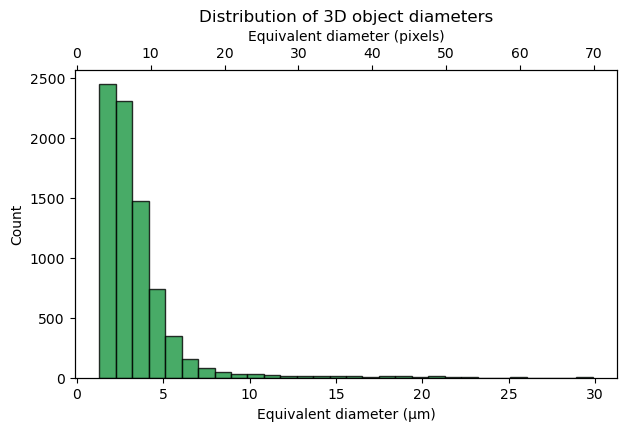

In [52]:
# --- assume you already have `masks` as a 3D array ---
# voxel size in µm (Z, Y, X) from metadata
voxel_size = np.array([0.5, 0.391, 0.391])  # µm
mean_voxel = voxel_size.mean()  # for diameter conversion (approx isotropic scaling)

# --- collect diameters in µm ---
diameters_um = []
for r in tqdm(regionprops(masks)):
    voxel_count = r.area
    phys_volume = voxel_count * np.prod(voxel_size)
    eq_diam = (6 * phys_volume / np.pi) ** (1/3)
    diameters_um.append(eq_diam)

diameters_um = np.array(diameters_um)
diameters_px = diameters_um / mean_voxel   # approximate diameters in pixels

# --- plot histogram with twin x-axes ---
fig, ax1 = plt.subplots(figsize=(7,4))

# histogram in µm
ax1.hist(diameters_um, bins=30, color="#1a9641", edgecolor="black", alpha=0.8)
ax1.set_xlabel("Equivalent diameter (µm)")
ax1.set_ylabel("Count")

# second x axis for pixels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim()[0]/mean_voxel, ax1.get_xlim()[1]/mean_voxel)
ax2.set_xlabel("Equivalent diameter (pixels)")

plt.title("Distribution of 3D object diameters")
plt.show()

{'z_index': 310, 'n_objs': 222, 'median_px': 6.076507779746499, 'iqr_px': (3.1915382432114616, 10.570056194378964), 'anisotropy': np.float64(1.278772378516624)}


(array([152.,  41.,   6.,   5.,   4.,   3.,   5.,   2.,   2.,   2.]),
 array([ 1.12837917,  9.25888975, 17.38940033, 25.51991092, 33.6504215 ,
        41.78093209, 49.91144267, 58.04195325, 66.17246384, 74.30297442,
        82.43348501]),
 <BarContainer object of 10 artists>)

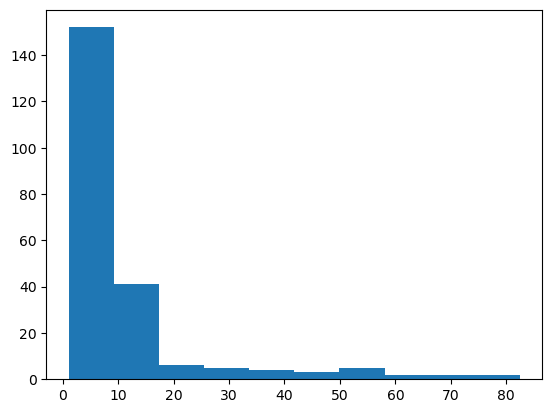

In [57]:
# --- inputs ---
z_index = 310
slice_2d = masks[z_index]   # (Y, X) labels at Z=310

# --- compute diameters in pixels ---
diam_px_xy = []
d_eqs = []
for r in regionprops(slice_2d):
    area_px = r.area
    d_eq = 2 * np.sqrt(area_px / np.pi)   # equivalent circle diameter in pixels
    diam_px_xy.append(d_eq)
    d_eqs.append(d_eq)

diam_px_xy = np.array(diam_px_xy)
if diam_px_xy.size > 0:
    med_px = float(np.median(diam_px_xy))
    q1_px  = float(np.percentile(diam_px_xy, 25))
    q3_px  = float(np.percentile(diam_px_xy, 75))
else:
    med_px, q1_px, q3_px = (np.nan, np.nan, np.nan)

# Recommended Cellpose params (still needs anisotropy for 3D runs)
voxel = np.array([0.5, 0.391, 0.391])  # (z, y, x) µm
anisotropy = voxel[0] / voxel[1]

print({
    "z_index": z_index,
    "n_objs": len(diam_px_xy),
    "median_px": med_px,
    "iqr_px": (q1_px, q3_px),
    "anisotropy": anisotropy
})

plt.hist(d_eqs)

### Iterate

In [59]:
from pathlib import Path
from natsort import natsorted
from tqdm.auto import tqdm
import numpy as np
import czifile

In [ ]:
# --- CONFIG ---
files_dir = Path(r"Y:\The_Holy_de_Broglies\Becca\zeisslightsheet7\20250814")
out_dir   = Path(files_dir, "labels"); out_dir.mkdir(exist_ok=True)
Z_AXIS    = 0       # z is first axis after selecting channel
DIAMETER  = 50    # set if you know it; None lets Cellpose infer

# --- NATURAL SORT + ITERATE ---
files = natsorted(Path(files_dir).glob("*.czi"), key=lambda p: str(p))

for fn in tqdm(files, desc="Segmenting 3D volumes"):
    arr = np.squeeze(czifile.imread(str(fn)))  # load raw array

    if arr.ndim == 4:
        # take the last channel from first axis
        vol = arr[-1]   # shape (Z, Y, X)
    elif arr.ndim == 3:
        vol = arr       # already (Z, Y, X)
    else:
        raise ValueError(f"Unexpected shape {arr.shape} from {fn.name}")

    # normalize intensities (robust percentile scaling)
    vmin, vmax = np.percentile(vol, (1, 99.8))
    seg_input = np.clip((vol.astype(np.float32) - vmin) / max(vmax - vmin, 1e-6), 0, 1)

    masks, flows, styles = model.eval(
        seg_input,
        do_3D=True,
        z_axis=Z_AXIS,
        diameter=DIAMETER,
    )

    out_fn = out_dir / (fn.stem + "_3d.npy")
    np.save(out_fn, masks)

Segmenting 3D volumes:   0%|                           | 0/153 [00:00<?, ?it/s]

In [ ]:

# --- visualize in napari ---
viewer = napari.Viewer(title="Pseudo-max segmentation")
viewer.add_image(combo, name="combo(ZYX)")
viewer.add_labels(masks, name="masks")
print("combo:", combo.shape, "masks:", masks.shape)